In [1]:
#numeric: pandas and numpy
import numpy as np
import pandas as pd
# graphics
%matplotlib inline 

import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 
import seaborn as sns

from sklearn import linear_model, svm, preprocessing, tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report, f1_score
from matplotlib.colors import ListedColormap

In [2]:
df = pd.read_csv('data/sensoringData_feature_prepared_20_19.0_2.csv',header = 0)

# remove useless collumns
df.drop('id',axis=1,inplace=True)
df.drop('user',axis=1,inplace=True)
df.drop('timestamp',axis=1,inplace=True)

feature_list = list(df.columns[:-2])
print("Number of Features: ",len(feature_list))
#print(df.head())

# print the number of missing values
df.isnull().sum()

Number of Features:  90


acc_xs_mean         0
acc_ys_mean         0
acc_zs_mean         0
acc_xs_var          0
acc_ys_var          0
                   ..
gps_speed_iqr       0
gps_bearing_iqr     0
gps_accuracy_iqr    0
activity_id         0
activity            0
Length: 92, dtype: int64

In [3]:
print("Label names: ",df['activity'].unique())

# label_encoder object knows how to understand word labels.   - NOT NECESSARY
#label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'species'.
#df['activity']= label_encoder.fit_transform(df['activity'])
 
y=df.values[:,-1]
#Y = np.array(y).astype(int)
#print(y)

X=df.values[:,0:-2]
print(f"Features: {len(X[0])}")
print(f"Examples: {len(X)}")

Label names:  ['Walking' 'Inactive' 'Active' 'Driving']
Features: 90
Examples: 499276


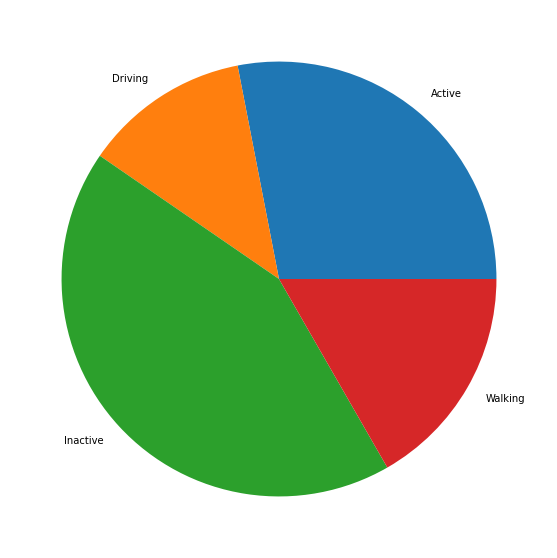

In [6]:
labels = np.unique(y)
#print(labels)
quantity = [np.sum(y == label) for label in labels]
#print(quantity)
#print(sum(quantity))

# Creating plot 
fig = plt.figure(figsize =(20, 10)) 
plt.pie(quantity, labels=labels) 
  
# show plot 
plt.show()

In [5]:
# fOR VISUALIZATION TESTS

# Separating the data 
dfW=df[df['activity'] == "Walking"]
dfA=df[df['activity'] == "Active"]
dfI=df[df['activity'] == "Inactive"]
dfD=df[df['activity'] == "Driving"]
"""
#Creating the window with 10 subplots.
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(7,10))
axes = axes.ravel()
#Creating histograms with 50 bins
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(df[feature_list[idx]]) - min(df[feature_list[idx]]))/40
    ax.hist([dfW[feature_list[idx]],dfI[feature_list[idx]],dfA[feature_list[idx]],dfD[feature_list[idx]]], bins=np.arange(min(df[feature_list[idx]]), max(df[feature_list[idx]]) + binwidth, binwidth) , alpha=0.8,stacked=True, density= True, label=['W','I','A','D'],color=['b','g','orange','r'])
    ax.legend(loc='upper right')
    ax.set_title(feature_list[idx])
plt.tight_layout()
plt.show()"""

"\n#Creating the window with 10 subplots.\nplt.rcParams.update({'font.size': 8})\nfig, axes = plt.subplots(nrows=4, ncols=3, figsize=(7,10))\naxes = axes.ravel()\n#Creating histograms with 50 bins\nfor idx,ax in enumerate(axes):\n    ax.figure\n    binwidth= (max(df[feature_list[idx]]) - min(df[feature_list[idx]]))/40\n    ax.hist([dfW[feature_list[idx]],dfI[feature_list[idx]],dfA[feature_list[idx]],dfD[feature_list[idx]]], bins=np.arange(min(df[feature_list[idx]]), max(df[feature_list[idx]]) + binwidth, binwidth) , alpha=0.8,stacked=True, density= True, label=['W','I','A','D'],color=['b','g','orange','r'])\n    ax.legend(loc='upper right')\n    ax.set_title(feature_list[idx])\nplt.tight_layout()\nplt.show()"

In [8]:
# Anova selection - GET BEST FEATURES

def get_best_x_features(X, y, num_features=40):
    #df = (df - np.min(df))/(np.max(df) - np.min(df))
    
    k_bestfeatures = SelectKBest(score_func = f_classif, k=num_features)
    k_bestfeatures.fit(X, y)
    
    # what are scores for the features
    #for i in range(len(rankings.scores_)):
        #print('Feature %d: %f' % (i, rankings.scores_[i]))
    
    # transform train input data
    X_best = k_bestfeatures.transform(X)
    return X_best
        

In [9]:
X_best = get_best_x_features(X,y,10)
print(f"Features: {len(X_best[0])}")
print(f"Examples: {len(X_best)}")

Features: 10
Examples: 499276


## Train-Test Split

#### Extract X and y in order to test the models later

In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(X_best, y, test_size=0.5,random_state=109) # 50% training and 50% test
print("Examples to train: {}".format(len(X_temp)))

Examples to train: 249638


# Models Evaluation

#### Large Dataset - Holdout method, not Cross validation
#### We use the f-score metric to evaluate de model considering that our dataset is unbalanced, so accuracy is not recommended.

In [11]:
# Split train dataset - Train and Validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.4,random_state=109) # 60% training and 40% validation
print("Examples to train: {}".format(len(X_train)))

Examples to train: 149782


### Models Functions

In [12]:
#Create a linear svm Classifier
def linear_svm(c):
    l_svm = svm.SVC(kernel="linear", C=c)
    l_svm.fit(X_train, y_train)
    y_pred = l_svm.predict(X_valid)
    f1 = f1_score(y_valid, y_pred, average='micro')
    
    return f1
    
    #return run_kFold(l_svm, X_train, y_train)

In [13]:
#Create a RBF svm Classifier
def rbf_svm(c):
    rbf_svm = svm.SVC(C=c,kernel='rbf')
    rbf_svm.fit(X_train, y_train)
    y_pred = rbf_svm.predict(X_valid)
    f1 = f1_score(y_valid, y_pred, average='micro')
    
    return f1

    #return run_kFold(rbf_svm, X_train, y_train)

In [14]:
# K-Nearest Neighbors
def knn(n_neigh, metric='euclidean'):
    k_n_n = KNeighborsClassifier(n_neighbors=n_neigh, metric=metric)
    k_n_n.fit(X_train, y_train)
    y_pred = k_n_n.predict(X_valid)
    f1 = f1_score(y_valid, y_pred, average='micro')
    
    return f1

    #return run_kFold(k_n_n, X_train, y_train)

In [15]:
# Decision Tree
def dtree(criterion, max_depth):
    clf = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    f1 = f1_score(y_valid, y_pred, average='micro')
    
    return f1
    #return run_kFold(clf, X_train, y_train)

In [16]:
# Random Forest
def rf(n_estimators, max_depth):
    #Create a Gaussian Classifier
    r_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    r_forest.fit(X_train, y_train)
    y_pred = r_forest.predict(X_valid)
    f1 = f1_score(y_valid, y_pred, average='micro')
    
    return f1

    #return run_kFold(r_forest, X_train, y_train)

## Training the models with different hyper-parameters

### Decision Tree

In [31]:
# Define our candidate hyperparameters
hp_candidates_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [2,4,8,15,20,25]}

best_hp_dt = {'f1':0, 'candidates': (' ',0)}
for cri in hp_candidates_dt['criterion']:
    for max_ in hp_candidates_dt['max_depth']:
        dt_f1 = dtree(cri, max_)
        print(dt_f1)
        if dt_f1 > best_hp_dt['f1']:
            candidates = (cri, max_)
            best_hp_dt['f1'] = dt_f1
            best_hp_dt['candidates'] = candidates
            
print("Best: ",best_hp_dt)

0.7864825348501843
0.908097660631309
0.9277058964909469
0.9448405704214068
0.9506289056240987
0.9505187469956737
0.790017625380548
0.9096098381669604
0.9273854350264382
0.9456417240826791
0.9504486460503124
0.949677535651338
Best:  {'f1': 0.9506289056240987, 'candidates': ('gini', 20)}


### Random Forest

In [ ]:
# Define our candidate hyperparameters
hp_candidates_rf = {'n_estimators': [10, 50, 100, 200], 'max_depth': [3,10,80, 90, 110]}

best_hp_rf = {'f1':0, 'candidates': (0,0)}
for est in hp_candidates_rf['n_estimators']:
    for max_ in hp_candidates_rf['max_depth']:
        rf_f1 = rf(est, max_)
        print(rf_f1, est,max_)
        if rf_f1 > best_hp_rf['f1']:
            candidates = (est, max_)
            best_hp_rf['f1'] = rf_f1
            best_hp_rf['candidates'] = candidates
            
print("Best: ",best_hp_rf)

0.911512578112482 10 3
0.9385114564973562 10 10
0.9620353308764621 10 80
0.961754927095017 10 90
0.96245593654863 10 110
0.9135555199487262 50 3
0.9386716872296106 50 10
0.9656104790898894 50 80
0.9656405223521871 50 90
0.9653801474122736 50 110
0.9103308764621054 100 3
0.9387518025957379 100 10
0.9661512578112482 100 80


### K-Nearest Neighbors

In [75]:
# Define our candidate hyperparameters
hp_candidates_knn = {'n_neighbors': [3,7], 'metrics': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}

best_hp_knn = {'f1':0, 'candidates': (3,' ')}
for nei in hp_candidates_knn['n_neighbors']:
    for met in hp_candidates_knn['metrics']:
        knn_f1 = knn(nei, met)
        if knn_f1 > best_hp_knn['f1']:
            candidates = (nei, met)
            best_hp_knn['f1'] = knn_f1
            best_hp_knn['candidates'] = candidates
            
print("Best: ",best_hp_knn)

Best:  {'f1': 0.9497871779732483, 'candidates': (3, 'manhattan')}


### Linear SVM 

In [18]:
# Define our candidate hyperparameters
hp_candidates_linear = {'C': [0.1, 0.3, 1, 3]}

best_hp_linear = {'f1':0, 'C': 0.01}
for c in hp_candidates_linear['C']:
    svm_linear_f1 = linear_svm(c)
    print(svm_linear_f1)
    if svm_linear_f1 > best_hp_linear['f1']:
        best_hp_linear['f1'] = svm_linear_f1
        best_hp_linear['C'] = c
            
print("Best: ",best_hp_linear)

1 Done!
1 Done!
1 Done!
1 Done!
0.818947458437815
1 Done!
1 Done!
1 Done!
1 Done!
0.8323368762021597
1 Done!
1 Done!
1 Done!
1 Done!
0.8426718659462824
1 Done!
1 Done!
1 Done!
1 Done!
0.8487106306694587
1 Done!
1 Done!
1 Done!
1 Done!
0.8534274729965194
1 Done!
1 Done!
1 Done!
1 Done!
0.8564718894041695
Best:  {'f1': 0.8564718894041695, 'C': 3}


### RBF SVM

In [ ]:
# Define our candidate hyperparameters
hp_candidates_rbf = {'C': [0.1, 0.3, 1, 3]}

best_hp_rbf = {'f1':0, 'C': 0.01}
for c in hp_candidates_rbf['C']:
    svm_rbf_f1 = rbf_svm(c)
    print(svm_rbf_f1)
    if svm_rbf_f1 > best_hp_rbf['f1']:
        best_hp_rbf['f1'] = svm_rbf_f1
        best_hp_rbf['C'] = c
            
print("Best: ",best_hp_rbf)

# Final models comparison

#### Create the model with best hyperparameters.
#### Trainning set now is trainning + validation (temp set)

In [20]:
def printConfMatrix(cf_matrix,model):
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title('Confusion Matrix - '+model);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Active', 'Driving', 'Inactive', 'Walking'])
    ax.yaxis.set_ticklabels(['Active', 'Driving', 'Inactive', 'Walking'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [21]:
f1_results = {}

labels_results = {0:[], 1:[], 2:[], 3: []}  # 0:'Active', 1:'Driving', 2:'Inactive', 3:'Walking'
labels_results_2 = {0: [0.9409446334022933, 0.9625251474158862, 0.9619872938422377, 0.78350992], 1: [0.9620332086368708, 0.9759838680352391, 0.9754826444655674, 0.90130257], 2: [0.9831320798785472, 0.9892967358773787, 0.9860812061404528, 0.89000842], 3: [0.9169707805726323, 0.945737788818015, 0.9424106923492702, 0.8435081]}

In [22]:
#Decision Tree
final_dt = tree.DecisionTreeClassifier(criterion='gini', max_depth=20)
final_dt.fit(X_temp, y_temp)
print("Model created!")
y_pred = final_dt.predict(X_test)
print("Prediction done!")

cm_dt = confusion_matrix(y_test, y_pred)
f1_dt = f1_score(y_test, y_pred, average=None)
f1_dt_micro = f1_score(y_test, y_pred, average='micro')
for i in range(len(labels_results)):
    labels_results[i].append(f1_dt[i])

f1_results["dt"] = f1_dt
print("F1 Score: ",f1_dt)
print(labels_results)

Model created!
Prediction done!
F1 Score:  [0.94084843 0.96196633 0.98322571 0.91670446]
{0: [0.9408484254037202], 1: [0.961966330850261], 2: [0.9832257099870105], 3: [0.9167044632678328]}


In [23]:
#Random Forest
final_r_forest = RandomForestClassifier(n_estimators=200, max_depth=80)
final_r_forest.fit(X_temp, y_temp)
print("Model created!")
y_pred = final_r_forest.predict(X_test)
print("Prediction done!")

cm_rf = confusion_matrix(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred, average=None)
f1_rf_micro = f1_score(y_test, y_pred, average='micro')
for i in range(len(labels_results)):
    labels_results[i].append(f1_rf[i])

f1_results["rf"] = f1_rf
print("F1 Score: ",f1_rf)

Model created!
Prediction done!
F1 Score:  [0.96246567 0.9755783  0.98928661 0.94566289]


In [24]:
#KNN
final_knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
final_knn.fit(X_temp, y_temp)
print("Model created!")
y_pred = final_knn.predict(X_test)
print("Prediction done!")
cm_knn = confusion_matrix(y_test, y_pred)

f1_knn = f1_score(y_test, y_pred, average=None)
f1_knn_micro = f1_score(y_test, y_pred, average='micro')
for i in range(len(labels_results)):
    labels_results[i].append(f1_knn[i])
    
f1_results["knn"] = f1_knn
print("F1 Score: ",f1_knn)
print(labels_results)

Model created!
Prediction done!
F1 Score:  [0.96198729 0.97548264 0.98608121 0.94241069]
{0: [0.9408484254037202, 0.9624656698199574, 0.9619872938422377], 1: [0.961966330850261, 0.9755782999057524, 0.9754826444655674], 2: [0.9832257099870105, 0.9892866133949967, 0.9860812061404528], 3: [0.9167044632678328, 0.9456628927363284, 0.9424106923492702]}


In [25]:
#RBF SVM
final_svm = svm.SVC(C=3,kernel='rbf')
final_svm.fit(X_temp, y_temp)
print("Model created!")
y_pred = final_svm.predict(X_test)
print("Prediction done!")

cm_svm = confusion_matrix(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred, average=None)
f1_svm_micro = f1_score(y_test, y_pred, average='micro')
for i in range(len(labels_results)):
    labels_results[i].append(f1_svm[i])
    
f1_results["svm"] = f1_svm
print("F1 Score: ",f1_svm)

Model created!
Prediction done!
F1 Score:  [0.80181748 0.9052419  0.89887178 0.84579888]


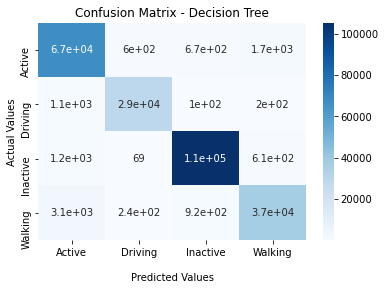

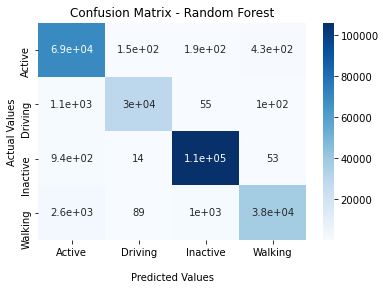

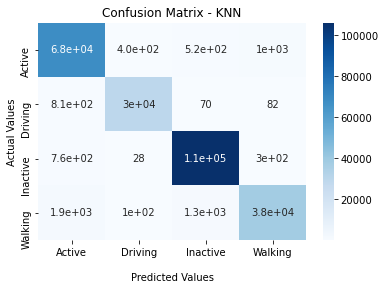

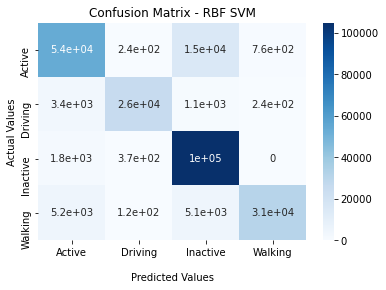

In [26]:
# Confusion Matrixes
printConfMatrix(cm_dt, "Decision Tree")
printConfMatrix(cm_rf, "Random Forest")
printConfMatrix(cm_knn, "KNN")
printConfMatrix(cm_svm, "RBF SVM")

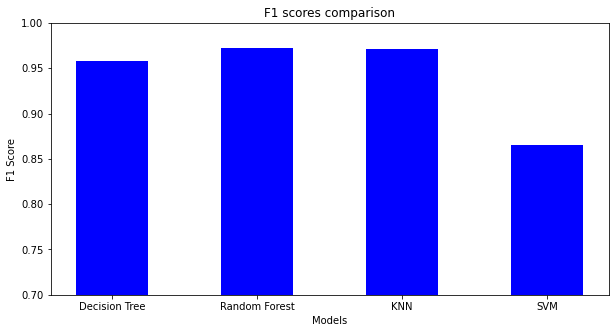

In [28]:
# Compare f1 scores - avg = "micro" is best for unbalanced datasets

values = [f1_dt_micro, f1_rf_micro, f1_knn_micro, f1_svm_micro]
models = ["Decision Tree", "Random Forest", "KNN", "SVM"]

fig = plt.figure(figsize = (10, 5))
#  Bar plot
plt.bar(models, values, color ='blue',
        width = 0.5)
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("F1 scores comparison")
plt.ylim(0.7,1)
plt.show()

Text(0, 0.5, 'F1 Score')

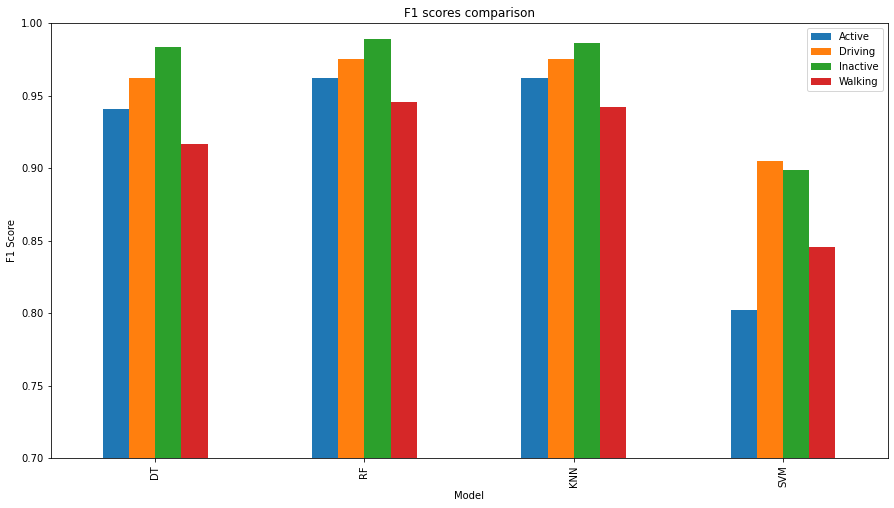

In [30]:
# Compare f1 scores - avg = None

plotdata = pd.DataFrame({

    "Active":labels_results[0],

    "Driving":labels_results[1],
    
    "Inactive":labels_results[2],

    "Walking":labels_results[3]},

    index=["DT", "RF", "KNN", "SVM"])

plotdata.plot(kind="bar",figsize=(15, 8))

plt.title("F1 scores comparison")

plt.xlabel("Model")
plt.ylim(0.7,1)
plt.ylabel("F1 Score")